# Glove +BiLSTM Sentiment analsysis on Amazon Cell Phones Reviews

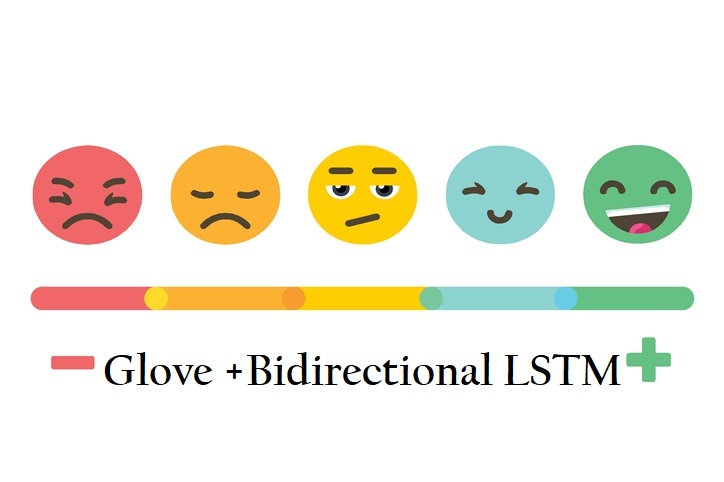

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mrvmurali","key":"b52d02bd18b2eed468ba2144e5ad2c6b"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d grikomsn/amazon-cell-phones-reviews

  0% 0.00/8.84M [00:00<?, ?B/s]
100% 8.84M/8.84M [00:00<00:00, 80.9MB/s]


In [5]:
!unzip "/content/amazon-cell-phones-reviews.zip"

Archive:  /content/amazon-cell-phones-reviews.zip
  inflating: 20191226-items.csv      
  inflating: 20191226-reviews.csv    


## Importing the Required Libraries

In [76]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
from tensorflow.keras import regularizers



from collections import Counter

import os, re, csv, math, codecs
import pandas as pd
import numpy as np
import tqdm
import sklearn


from tensorflow.keras.preprocessing import sequence,text
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Embedding,LSTM,Conv1D,GlobalMaxPooling1D,Flatten,MaxPooling1D,GRU,SpatialDropout1D,Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import BinaryAccuracy
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,f1_score


import seaborn as sns

import pydot
# Logging
import warnings
warnings.filterwarnings('ignore')
import logging
logging.basicConfig(level=logging.INFO)

In [7]:
print(tf.__version__)

2.5.0


In [8]:
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))

else:
    print("Please install GPU version of TF")

Please install GPU version of TF


 ## pre-process the review data

In [9]:
def clean_text(text ): 
    delete_dict = {sp_character: '' for sp_character in string.punctuation} 
    delete_dict[' '] = ' ' 
    table = str.maketrans(delete_dict)
    text1 = text.translate(table)
    #print('cleaned:'+text1)
    textArr= text1.split()
    text2 = ' '.join([w for w in textArr if ( not w.isdigit() and  ( not w.isdigit() and len(w)>2))]) 
    
    return text2.lower()



## Read the data

In [10]:
review_data= pd.read_csv("/content/20191226-reviews.csv")
review_data.head(10)

,asin,name,rating,date,verified,title,body,helpfulVotes
0,B0000SX2UC,Janet,3,"October 11, 2005",False,"Def not best, but not worst",I had the Samsung A600 for awhile which is abs...,1.0
1,B0000SX2UC,Luke Wyatt,1,"January 7, 2004",False,Text Messaging Doesn't Work,Due to a software issue between Nokia and Spri...,17.0
2,B0000SX2UC,Brooke,5,"December 30, 2003",False,Love This Phone,"This is a great, reliable phone. I also purcha...",5.0
3,B0000SX2UC,amy m. teague,3,"March 18, 2004",False,"Love the Phone, BUT...!","I love the phone and all, because I really did...",1.0
4,B0000SX2UC,tristazbimmer,4,"August 28, 2005",False,"Great phone service and options, lousy case!",The phone has been great for every purpose it ...,1.0
5,B0000SX2UC,J. White,4,"September 25, 2005",False,Worked great for me,"Hello, I have this phone and used it until I d...",NaN
6,B0000SX2UC,the cell phone store owner,5,"April 16, 2004",False,Wanna cool Nokia? You have it here!,Cool. Cheap. Color: 3 words that describe the ...,2.0
7,B0000SX2UC,Matt,4,"April 3, 2004",False,Problem with 3588i universal headset,"The 3599i is overall a nice phone, except that...",2.0
8,B0000SX2UC,Charles Cook,5,"November 24, 2003",False,cool phone!!!!!!!!,"I've never owned a Nokia phone before, so this...",7.0
9,B0000SX2UC,Amazon Customer,3,"February 2, 2004",False,Pissed off-a little bit,ok well im in school and i need the text messa...,3.0


In [11]:
print("The dataset contains {0[0]: .0f} rows and {0[1]: .0f} variables.".format(review_data.shape))

The dataset contains  67986 rows and  8 variables.


In [12]:
review_data["reviewText"]=review_data['title']+review_data["body"]

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


In [13]:
review_data = review_data.rename(columns = {'overall': 'rating', 'asin': 'productID'}, inplace = False)

In [14]:
review_data.dropna(axis = 0, how ='any',inplace=True) 

In [15]:
review_data['reviewText'] = review_data['reviewText'].apply(clean_text)
review_data['Num_words_text'] = review_data['reviewText'].apply(lambda x:len(str(x).split())) 

In [16]:
print(review_data['rating'].value_counts())

5    12960
1     7061
4     3280
3     2032
2     1873
Name: rating, dtype: int64


In [17]:
print(len(review_data))
max_review_data_sentence_length  = review_data['Num_words_text'].max()

print('Train Max Sentence Length :'+str(max_review_data_sentence_length))

27206
Train Max Sentence Length :4249


In [18]:
review_data['Num_words_text'].describe()

count    27206.000000
mean        74.670440
std        129.866469
min          0.000000
25%         17.000000
50%         38.000000
75%         81.000000
max       4249.000000
Name: Num_words_text, dtype: float64

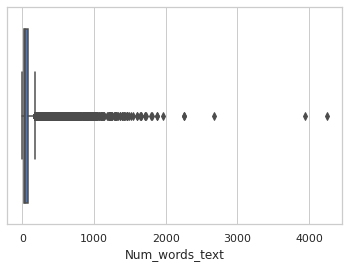

In [19]:
sns.set(style="whitegrid")
sns.boxplot(x=review_data['Num_words_text'])

### create a dataset having reviews of 100 words or less

In [20]:
mask = (review_data['Num_words_text'] < 100) & (review_data['Num_words_text'] >=20)
df_short_reviews = review_data[mask]
print('No of Short reviews')
print(len(df_short_reviews))

No of Short reviews
14036


In [21]:
mask = review_data['Num_words_text'] >= 100
df_long_reviews = review_data[mask]
print('No of Long reviews')
print(len(df_long_reviews))

No of Long reviews
5287


In [22]:
print(df_short_reviews['Num_words_text'].max())

99


In [23]:
def get_sentiment(rating):
    if rating == 5 or rating == 4 or rating ==3:
        return 1
    else:
        return 0
    

## create train and test datasets

In [24]:
filtered_data = df_short_reviews.groupby('productID').filter(lambda x: len(x) >= 20)
print(len(filtered_data))
print(filtered_data ['rating'].value_counts())

11406
5    4891
1    3348
4    1378
3     929
2     860
Name: rating, dtype: int64


In [25]:
filtered_data ['sentiment'] = filtered_data ['rating'].apply(get_sentiment)
train_data = filtered_data[['reviewText','sentiment']]
print('Train data')
print(train_data['sentiment'].value_counts())

Train data
1    7198
0    4208
Name: sentiment, dtype: int64


In [26]:
#Create Test Data
mask = review_data['Num_words_text'] < 100 
df_short_reviews = review_data[mask]
filtered_data = df_short_reviews.groupby('productID').filter(lambda x: len(x) >= 10)
print(len(filtered_data))
print(filtered_data ['rating'].value_counts())

20926
5    10199
1     5679
4     2279
3     1450
2     1319
Name: rating, dtype: int64


In [27]:
filtered_data ['sentiment'] = filtered_data ['rating'].apply(get_sentiment)
test_data = filtered_data[['reviewText','sentiment']]
print('Test data')
print(test_data['sentiment'].value_counts())

Test data
1    13928
0     6998
Name: sentiment, dtype: int64


In [28]:
train_data['sentiment'].value_counts()

1    7198
0    4208
Name: sentiment, dtype: int64

In [29]:
X_train, X_valid, y_train, y_valid = train_test_split(train_data['reviewText'].tolist(),\
                                                      train_data['sentiment'].tolist(),\
                                                      test_size=0.3,\
                                                      stratify = train_data['sentiment'].tolist(),\
                                                      random_state=0)


print('Train data len:'+str(len(X_train)))
print('Class distribution'+str(Counter(y_train)))
print('Valid data len:'+str(len(X_valid)))
print('Class distribution'+ str(Counter(y_valid)))

Train data len:7984
Class distributionCounter({1: 5038, 0: 2946})
Valid data len:3422
Class distributionCounter({1: 2160, 0: 1262})


In [30]:
num_words = 50000

tokenizer = Tokenizer(num_words=num_words,oov_token="unk")
tokenizer.fit_on_texts(X_train)
print(str(tokenizer.texts_to_sequences(['xyz how are you'])))

[[1, 161, 33, 14]]


## create train,validation and test tensorflow datasets


### Convert the tokens into sequences

In [31]:
x_train = np.array( tokenizer.texts_to_sequences(X_train) )
x_valid = np.array( tokenizer.texts_to_sequences(X_valid) )
x_test  = np.array( tokenizer.texts_to_sequences(test_data['reviewText'].tolist()) )

### Add post padding with maxlenth

In [32]:
x_train = pad_sequences(x_train, padding='post', maxlen=100)
x_valid = pad_sequences(x_valid, padding='post', maxlen=100)
x_test = pad_sequences(x_test, padding='post', maxlen=100)

In [33]:
train_labels = np.asarray(y_train )
valid_labels = np.asarray( y_valid)
test_labels = np.asarray(test_data['sentiment'].tolist())

In [34]:
print('Train data len:'+str(len(x_train)))
print('Class distribution'+str(Counter(train_labels)))

print('Validation data len:'+str(len(x_valid)))
print('Class distribution'+str(Counter(valid_labels)))

print('Test data len:'+str(len(x_test)))
print('Class distribution'+str(Counter(test_labels)))

Train data len:7984
Class distributionCounter({1: 5038, 0: 2946})
Validation data len:3422
Class distributionCounter({1: 2160, 0: 1262})
Test data len:20926
Class distributionCounter({1: 13928, 0: 6998})


In [35]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train,train_labels))
valid_ds = tf.data.Dataset.from_tensor_slices((x_valid,valid_labels))
test_ds = tf.data.Dataset.from_tensor_slices((x_test,test_labels))

In [36]:
count =0
print('======Train dataset ====')
for value,label in train_ds:
    count += 1
    print(value,label)
    if count==1:
        break


======Train dataset ====
tf.Tensor(
[  12 5457  129   25    3   28   15 1339   51   60  229    2  165  224
    4   17   61   12  278   20    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0], shape=(100,), dtype=int32) tf.Tensor(1, shape=(), dtype=int64)


In [37]:
count =0
print('======Validation dataset ====')
for value,label in valid_ds:
    count += 1
    print(value,label)
    if count==1:
        break

======Validation dataset ====
tf.Tensor(
[ 560   45   41   43  134   96  206    1   45   41    5  260   55  134
   96   65   47  878 1459   73   53  206   99  138  386  176   40    1
  572  407  179    4  135 4964   59 1092   33    8  542   14   45  141
  334  118 1912    8   41    5  260  607  118    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0], shape=(100,), dtype=int32) tf.Tensor(0, shape=(), dtype=int64)


In [38]:
count =0
print('======Test dataset ====')
for value,label in test_ds:
    count += 1
    print(value,label)
    if count==1:
        break  

======Test dataset ====
tf.Tensor(
[  435   344     7  6607   496     2 11058   344    15     7    97     4
  6689   311    46    20    97   204     1    54    10   150  1052   468
    87     4    38   101     8  4439   491     3  1118    15   160    65
    97     4  1781    11    38    13     8   477   491    46    97   336
   135   203    16   907    54     5  3839  1540 11117  4607     7   116
   211     3   321     5   842   203    48   289     4     8   913     2
    51    60   830     9     8    99     4    97    15  1130   145     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0], shape=(100,), dtype=int32) tf.Tensor(0, shape=(), dtype=int64)


## Downloading and Importing Glove Embeddings


In [40]:
!wget "https://nlp.stanford.edu/data/glove.6B.zip"

--2021-06-28 06:34:15--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-06-28 06:34:16--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.17MB/s    in 2m 48s  

2021-06-28 06:37:04 (4.90 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [44]:
!unzip  "/content/glove.6B.zip"

Archive:  /content/glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [45]:
glove_vector=dict()

In [46]:
file=open('/content/glove.6B.200d.txt',encoding='utf-8')

for line in file:
  values=line.split()
  word=values[0]
  vectors=np.asarray(values[1:])
  glove_vector[word]=vectors
file.close()

In [47]:
word_vector_matrix=np.zeros((num_words,200))

for word,index in tokenizer.word_index.items():
  vector=glove_vector.get(word)
  if vector is not None:
    word_vector_matrix[index]=vector
    embed_count = 0
  else:
    print(word)

Streaming output truncated to the last 5000 lines.
msgs
sellergreat
usaits
oldass
payasyougo
sghi337
m919
modesqualcomm
controllerfits
goeslike
goesyou
pixelfront
pixelback
smartphoneso
restoreupdate
25000great
horriblegot
browsingtaking
companywas
outstandingthis
cortanai
onstill
middlepriced
applestore
lasership
chargersent
incrediblei
sexbot
workwont
countrybeen
hourdisapointed
pastthis
us200
functionalit
hadmoved
yetwhat
asthetics
20gb
liewhile
availablefyi
functionslove
performanc
bluetoothwont
bluetoothing
goodgot
moneyextremely
waterotherwise
disappointmentunfortunately
phonecant
dataappsi
woukd
nokiai
issuethere
returnreplace
perlaced
orderedwhen
originalinside
bookearing
carger
8g256g
recorderill
extrapleasant
soundvideo
perfectbuying
headphonejack
impressedmy
christmastwas
processorthis
mapsbut
3day
kmffffttt
iphonesamsung
deliversmy
freezecrash
freezingcrashing
crashfreeze
buynokia
boxhad
glassi
servicefantastic
betteri
fatherthe
phonenever
zenphone
shipmentthe
professionalg

In [48]:
max_features =50000
embedding_dim =200
sequence_length = 100

## Bulid LSTM model

In [51]:
model = Sequential([
    Embedding(max_features , embedding_dim, input_length=sequence_length, weights = [word_vector_matrix],
                             trainable = False),
    Bidirectional(LSTM(32, return_sequences = True, dropout = 0.2, recurrent_dropout = 0.2)),
    GlobalMaxPooling1D(),
    Dropout(0.2),
    Dense(units=8, activation="relu"),
    Dense(units=1, activation="sigmoid")])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 200)          10000000  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 100, 64)           59648     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 520       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 10,060,177
Trainable params: 60,177
Non-trainable params: 10,000,000
_______________________________________

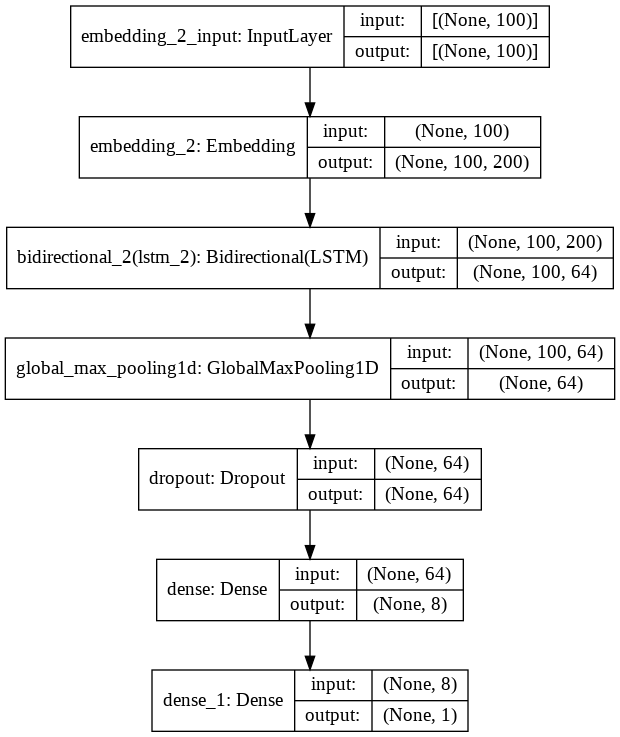

In [52]:
tf.keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

In [54]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),optimizer=tf.keras.optimizers.Adam(1e-3),metrics=[tf.keras.metrics.BinaryAccuracy()])

In [55]:
epochs = 10
history = model.fit(train_ds.shuffle(5000).batch(1024),
                    epochs= epochs ,
                    validation_data=valid_ds.batch(1024),
                    verbose=1)

Epoch 1/10
8/8 [==============================] - 35s 3s/step - loss: 0.6574 - binary_accuracy: 0.6260 - val_loss: 0.6389 - val_binary_accuracy: 0.6312
Epoch 2/10
8/8 [==============================] - 27s 3s/step - loss: 0.6273 - binary_accuracy: 0.6334 - val_loss: 0.5942 - val_binary_accuracy: 0.6400
Epoch 3/10
8/8 [==============================] - 26s 3s/step - loss: 0.5753 - binary_accuracy: 0.6854 - val_loss: 0.5184 - val_binary_accuracy: 0.7496
Epoch 4/10
8/8 [==============================] - 26s 3s/step - loss: 0.5002 - binary_accuracy: 0.7690 - val_loss: 0.4419 - val_binary_accuracy: 0.7969
Epoch 5/10
8/8 [==============================] - 26s 3s/step - loss: 0.4352 - binary_accuracy: 0.8039 - val_loss: 0.4030 - val_binary_accuracy: 0.8179
Epoch 6/10
8/8 [==============================] - 26s 3s/step - loss: 0.3939 - binary_accuracy: 0.8308 - val_loss: 0.3818 - val_binary_accuracy: 0.8255
Epoch 7/10
8/8 [==============================] - 28s 4s/step - loss: 0.3763 - binary_ac

## Plotting the accuracy and loss graphs

In [56]:
def plot_accuracy_loss(history):
    fig = plt.figure(figsize=(15,10))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['binary_accuracy'],'bo--', label=' training data')
    plt.plot(history.history['val_binary_accuracy'], 'ro--' ,label='validation data')
    plt.title('Accuracy for Text Classification')
    plt.ylabel('Accuracy value')
    plt.xlabel('No. epoch')
    plt.legend(loc="upper left")
    

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label=' training data')
    plt.plot(history.history['val_loss'],'ro--' , label='validation data')
    plt.title('Loss for Text Classification')
    plt.ylabel('Loss value')
    plt.xlabel('No. epoch')
    plt.legend(loc="upper left")
    plt.show()


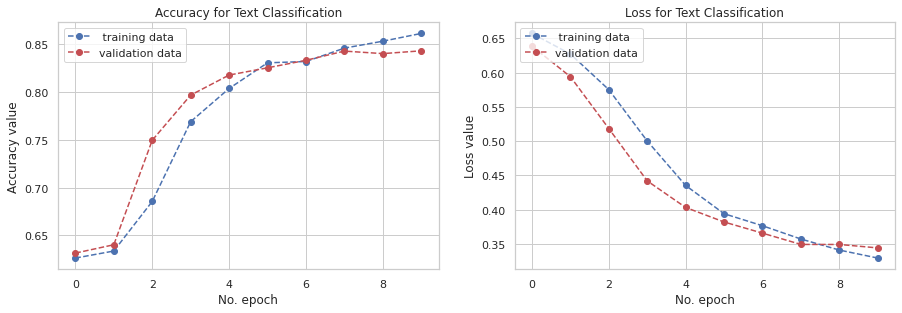

In [57]:
plot_accuracy_loss(history)

## save our model and tokenizer

In [58]:
model.save('tf_lstmmodel.h5') 
json_string = tokenizer.to_json()


In [59]:
import json
with open('tokenizer.json', 'w') as outfile:
    json.dump(json_string, outfile)
    

In [60]:
valid_predict= model.predict(x_valid)

In [61]:
print(valid_predict[:10])

[[0.04178166]
 [0.9122662 ]
 [0.6099735 ]
 [0.9794221 ]
 [0.9849956 ]
 [0.9512274 ]
 [0.37776428]
 [0.64594424]
 [0.7396235 ]
 [0.46498463]]


***
Code from : https://stackoverflow.com/questions/22518230/creating-a-threshold-coded-roc-plot-in-python


In [62]:
def plot_roc(name, labels, predictions, **kwargs):
    fig = plt.figure(figsize=(15,10))
    fp, tp, thresholds = sklearn.metrics.roc_curve(labels, predictions)
    plt.plot(fp, tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives Rate')
    plt.ylabel('True positives Rate')
    plt.xlim([-0.03, 1.0])
    plt.ylim([0.0, 1.03])
    plt.grid(True)
    thresholdsLength = len(thresholds)
    thresholds_every = 1000
    colorMap = plt.get_cmap('jet', thresholdsLength)
    for i in range(0, thresholdsLength, thresholds_every):
        threshold_value_with_max_four_decimals = str(thresholds[i])[:5]
        plt.text(fp[i] - 0.03, tp[i] + 0.001, threshold_value_with_max_four_decimals, fontdict={'size': 15}, color=colorMap(i/thresholdsLength));

    ax = plt.gca()
    ax.set_aspect('equal')

In [63]:
mpl.rcParams['figure.figsize'] = (16, 16)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

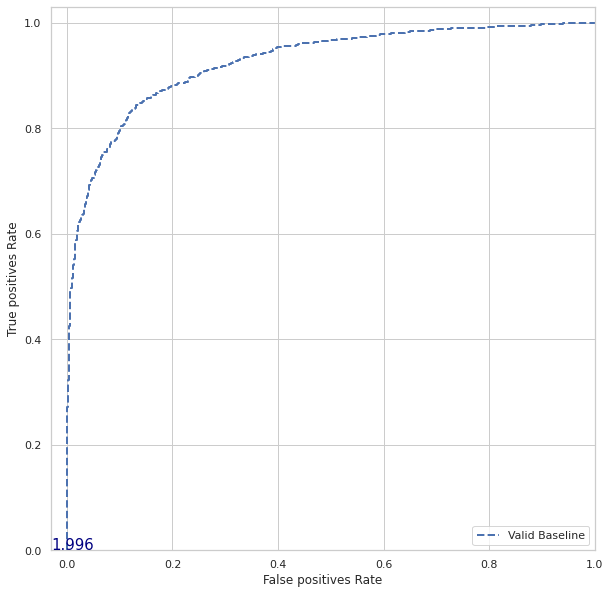

In [64]:
plot_roc("Valid Baseline", valid_labels, valid_predict, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

Lets load our model and test on test data

In [65]:
new_model = tf.keras.models.load_model('tf_lstmmodel.h5')
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 200)          10000000  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 100, 64)           59648     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 520       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 10,060,177
Trainable params: 60,177
Non-trainable params: 10,000,000
_______________________________________

In [66]:
with open('tokenizer.json') as json_file:
    json_string = json.load(json_file)
tokenizer1 = tf.keras.preprocessing.text.tokenizer_from_json(json_string)

In [67]:
x_test  = np.array( tokenizer.texts_to_sequences(test_data['reviewText'].tolist()) )
x_test = pad_sequences(x_test, padding='post', maxlen=100)

In [68]:
print("Generate predictions for all samples")
predictions = new_model.predict(x_test)



Generate predictions for all samples


In [69]:
test_data['pred_sentiment']= predictions
test_data['pred_sentiment'] = np.where((test_data.pred_sentiment >= 0.9),1,test_data.pred_sentiment)
test_data['pred_sentiment'] = np.where((test_data.pred_sentiment < 0.9),0,test_data.pred_sentiment)


In [70]:
labels = [0, 1]
    
print(classification_report(test_data['sentiment'].tolist(),test_data['pred_sentiment'].tolist(),labels=labels))

              precision    recall  f1-score   support

           0       0.54      0.97      0.69      6998
           1       0.97      0.58      0.73     13928

    accuracy                           0.71     20926
   macro avg       0.76      0.77      0.71     20926
weighted avg       0.83      0.71      0.71     20926



# Bidirectionl LSTM

In [77]:
max_features =50000
embedding_dim =200
sequence_length = 100


model = Sequential()
model.add(Embedding(max_features , embedding_dim, input_length=sequence_length, weights = [word_vector_matrix],
                             trainable = False))
model.add(SpatialDropout1D(0.25))
model.add(Bidirectional(LSTM(128,return_sequences=True)))
model.add(Bidirectional(LSTM(64,return_sequences=False)))
model.add(Dropout(0.5))

model.add(Dense(1,activation='sigmoid'))
                               



model.summary()
model.compile(loss=BinaryCrossentropy(),optimizer=Adam(1e-3),metrics=[BinaryAccuracy()])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 200)          10000000  
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 100, 200)          0         
_________________________________________________________________
bidirectional_7 (Bidirection (None, 100, 256)          336896    
_________________________________________________________________
bidirectional_8 (Bidirection (None, 128)               164352    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 10,501,377
Trainable params: 501,377
Non-trainable params: 10,000,000
____________________________________

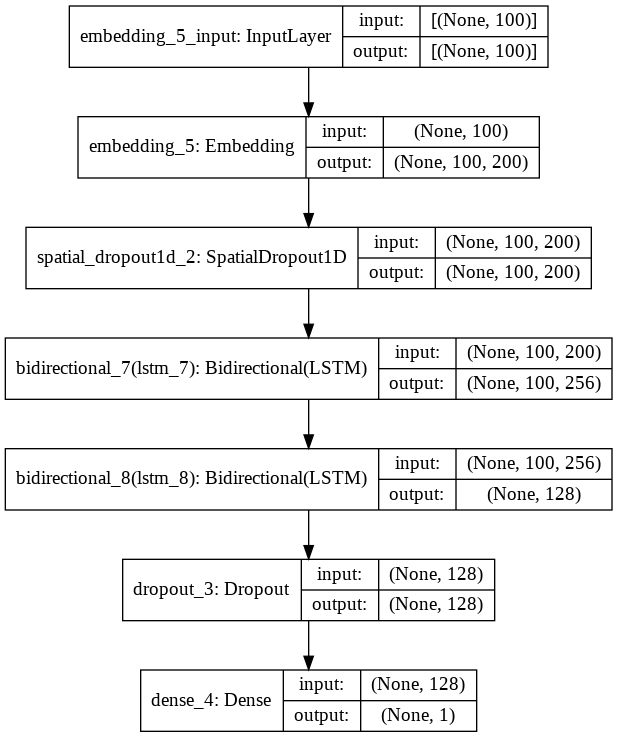

In [78]:
tf.keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

In [79]:
history = model.fit(train_ds.shuffle(5000).batch(1024),
                    epochs= epochs ,
                    validation_data=valid_ds.batch(1024),
                    verbose=1)

Epoch 1/10
8/8 [==============================] - 74s 8s/step - loss: 0.6510 - binary_accuracy: 0.6031 - val_loss: 0.5976 - val_binary_accuracy: 0.6414
Epoch 2/10
8/8 [==============================] - 62s 8s/step - loss: 0.5530 - binary_accuracy: 0.7088 - val_loss: 0.4589 - val_binary_accuracy: 0.7858
Epoch 3/10
8/8 [==============================] - 62s 8s/step - loss: 0.4601 - binary_accuracy: 0.7936 - val_loss: 0.4186 - val_binary_accuracy: 0.8068
Epoch 4/10
8/8 [==============================] - 62s 8s/step - loss: 0.4287 - binary_accuracy: 0.8057 - val_loss: 0.4075 - val_binary_accuracy: 0.8179
Epoch 5/10
8/8 [==============================] - 62s 8s/step - loss: 0.4034 - binary_accuracy: 0.8223 - val_loss: 0.3845 - val_binary_accuracy: 0.8288
Epoch 6/10
8/8 [==============================] - 62s 8s/step - loss: 0.3839 - binary_accuracy: 0.8347 - val_loss: 0.3706 - val_binary_accuracy: 0.8340
Epoch 7/10
8/8 [==============================] - 63s 8s/step - loss: 0.3792 - binary_ac

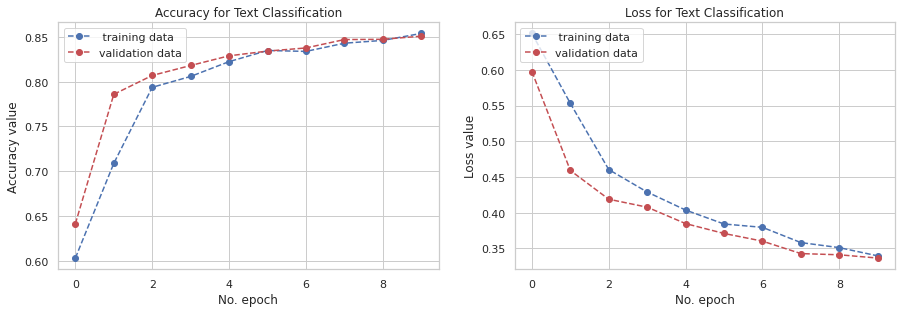

In [80]:
plot_accuracy_loss(history)